In [1]:
import pandas as pd 
import glob
import cv2 as cv
import random
import os

import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image
import PIL.ImageOps    

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from sklearn.metrics import f1_score, accuracy_score

from tqdm.auto import tqdm
import timm
import math
from sklearn.model_selection import train_test_split

import segmentation_models_pytorch as smp
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

c:\Users\EHmin\anaconda3\envs\EHmin\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# RLE 인코딩 함수
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = 'a'
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':30,
    'LEARNING_RATE':3e-4,
    # 'LEARNING_RATE':10,
    'BATCH_SIZE':8,
    'SEED':41
}

seed_everything(CFG['SEED']) # Seed 고정

In [3]:
class CustomDataset(Dataset):
    def __init__(self, source, gt, transform=None, infer=False):
        self.source = source
        self.gt = gt
        self.transform = transform
        self.infer = infer


    def __getitem__(self, idx):
        img_path = self.source[idx]
        image = cv.imread(img_path)
        # image = img_path
        
        label = self.gt[idx]
        # image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
        
        if self.infer:
            if self.transform:
                image = self.transform(image=image)['image']
            return image, label
        
        mask_path = self.gt[idx]
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE)
        mask[mask == 255] = 12 #/ 배경을 픽셀값 12로 간주 이거 원래 없던 값!

        if self.transform: # 알부네이션 먹이이는 형식으로 진행 
            augmented = self.transform(image=image, mask=mask) 
            image = augmented['image']
            mask = augmented['mask']
            
        return image, mask
    
    def __len__(self):
        return len(self.source)
    

In [4]:
transform = A.Compose(
    [   
        # A.Resize(224, 224),
        A.Normalize(),
        # ToTensorV2()
    ]
)

In [5]:
# #폴더 이동시 경로 수정이 필요할 수 있음 
# test_dataset = glob.glob("../Data/test_image/*")
# test_label = glob.glob("../DataPreprocessing/test_image/*")

# # glob 이후에 정렬이 안되어 있기 때문에, source - gt matching을 위해 정렬
# test_dataset.sort()

# print(test_dataset)

In [6]:
# df_test = pd.DataFrame(columns=['test'])
# df_test['test'] = test_dataset

# df_test

In [7]:
df_test = pd.read_csv('../DataPreprocessing/front_OR_back.csv')
df_test

,source,label
0,../Data/test_image\TEST_0000.png,1
1,../Data/test_image\TEST_0001.png,1
2,../Data/test_image\TEST_0002.png,1
3,../Data/test_image\TEST_0003.png,1
4,../Data/test_image\TEST_0004.png,1
...,...,...
1893,../Data/test_image\TEST_1893.png,0
1894,../Data/test_image\TEST_1894.png,0
1895,../Data/test_image\TEST_1895.png,1
1896,../Data/test_image\TEST_1896.png,0


In [8]:
test_dataset = CustomDataset(source = df_test['source'].values ,gt = df_test['label'].values , transform=None, infer=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0 )

# Add New pretrained model

In [9]:
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from PIL import Image
import requests
import cv2 as cv

feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024", size = {"height": 540,"width": 960})
# feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-512-1024")

# image = cv.imread("../Data/test_image/TEST_0005.png")

# inputs = feature_extractor(images=image, return_tensors="pt")
# outputs = model(**inputs)
# logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

c:\Users\EHmin\anaconda3\envs\EHmin\lib\site-packages\transformers\models\segformer\feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
c:\Users\EHmin\anaconda3\envs\EHmin\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:101: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [10]:
# from torch import nn

# upsampled_logits = nn.functional.interpolate(
#     logits,
#     size=image.shape[:2], # (height, width)
#     mode='bilinear',
#     align_corners=False
# )

# # Second, apply argmax on the class dimension
# out = upsampled_logits.argmax(dim=1).numpy()

In [11]:
city_to_12 = {
    0: 0,
    1: 1,
    2: 2,
    3: 3,
    4: 3,
    5: 4,
    6: 5,
    7: 6,
    8: 7,
    9: 7,
    10: 8,
    11: 9,
    12 : 10,
    13 : 11,
    14 : 11,
    15 : 11,
    16 : 11,
    17 : 11,
    18 : 11,
}

In [12]:
mask_0 = np.load("../DataPreprocessing/mask0.npy")
mask_1 = np.load("../DataPreprocessing/mask1.npy")


In [16]:
with torch.no_grad():
    # infer_model.eval()
    model = model.to(device)
    result = []
    for images, label in tqdm(test_loader):
        # images = images.float().to(device)
        # images = images.to(device)
        # print(images)
        # images = cv.imread(images)
        
        inputs = feature_extractor(images=images, return_tensors="pt")
        inputs = inputs.to(device)
        op = model(**inputs)
        outputs = op.logits
        
        outputs = nn.functional.interpolate(outputs,size=(540,960), mode='bilinear',align_corners=False)
        outputs = outputs.argmax( dim=1).to("cpu").numpy()
        
        # new_outputs = []
        # for row in outputs[0]:
        #     a = []
        #     for v in row:
        #       a.append(city_to_12[v])
        #     new_outputs.append(a)
        
        # new_outputs = np.array(new_outputs)
        # new_outputs = new_outputs.astype(np.uint8)
        
        # batch에 존재하는 각 이미지에 대해서 반복
        flag = True
        for pred , l in zip(outputs,label):
            new_pred = []
            for row in pred:
                a = []
                for v in row:
                    a.append(city_to_12[v])
                new_pred.append(a)
            new_pred = np.array(new_pred)
            new_pred = new_pred.astype(np.uint8)
            # print(new_pred.shape)
            
            if l == 0:
                new_pred[~mask_0] = 12
            else:
                new_pred[~mask_1] = 12
             
            if flag:   
                np.save('./test_img.npy', new_pred)
                flag = False
                
            # pred = pred.astype(np.uint8)
            # pred = Image.fromarray(pred) # 이미지로 변환
            # pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
            # pred = np.array(pred) # 다시 수치로 변환
            # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
            for class_id in range(12):
                class_mask = (new_pred == class_id).astype(np.uint8)
                if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
                    mask_rle = rle_encode(class_mask)
                    result.append(mask_rle)
                else: # 마스크가 존재하지 않는 경우 -1
                    result.append(-1)

  0%|          | 0/119 [00:00<?, ?it/s]

{'pixel_values': tensor([[[[-1.7240, -1.7925, -1.6384,  ..., -1.6555, -1.6555, -1.6384],
          [-1.8097, -1.8782, -1.7754,  ..., -1.7412, -1.7412, -1.7240],
          [-1.8268, -1.8439, -1.7240,  ..., -1.6384, -1.6384, -1.6384],
          ...,
          [-1.9980, -1.9980, -1.8782,  ..., -1.7240, -1.7240, -1.7240],
          [-1.8097, -1.8953, -1.7240,  ..., -1.8097, -1.8097, -1.8097],
          [-1.8953, -1.8439, -1.6898,  ..., -1.6042, -1.6042, -1.6384]],

         [[-1.8081, -1.8957, -1.7381,  ..., -1.5980, -1.5980, -1.5980],
          [-1.8957, -1.9482, -1.8782,  ..., -1.7206, -1.7206, -1.7031],
          [-1.9132, -1.9132, -1.8081,  ..., -1.6155, -1.6155, -1.6155],
          ...,
          [-2.0182, -2.0007, -1.8782,  ..., -1.7381, -1.7381, -1.7206],
          [-1.8606, -1.9307, -1.7556,  ..., -1.8081, -1.8081, -1.8081],
          [-1.9307, -1.8782, -1.7381,  ..., -1.6331, -1.6331, -1.6681]],

         [[-1.5081, -1.5953, -1.4384,  ..., -1.2816, -1.2816, -1.2641],
          [-1

  1%|          | 1/119 [00:05<10:54,  5.55s/it]

{'pixel_values': tensor([[[[-1.9980, -1.8782, -1.7754,  ..., -1.7240, -1.7240, -1.7240],
          [-2.0152, -1.8953, -1.8439,  ..., -1.6213, -1.6213, -1.6384],
          [-1.9467, -1.9124, -1.9295,  ..., -1.6555, -1.6555, -1.6727],
          ...,
          [-1.5870, -1.5014, -1.6555,  ..., -1.7925, -1.7925, -1.7925],
          [-1.7412, -1.7240, -1.9124,  ..., -1.6727, -1.6727, -1.6555],
          [-1.5870, -1.6213, -1.8953,  ..., -1.8097, -1.8097, -1.7754]],

         [[-2.0007, -1.8782, -1.7906,  ..., -1.7031, -1.7031, -1.7031],
          [-2.0007, -1.8782, -1.8431,  ..., -1.5980, -1.5980, -1.6155],
          [-1.9307, -1.8957, -1.9132,  ..., -1.6331, -1.6331, -1.6506],
          ...,
          [-1.4930, -1.4230, -1.5805,  ..., -1.7031, -1.7031, -1.7031],
          [-1.6856, -1.6331, -1.8081,  ..., -1.5980, -1.5980, -1.5630],
          [-1.5105, -1.5105, -1.7906,  ..., -1.7206, -1.7206, -1.6856]],

         [[-1.7696, -1.5953, -1.4559,  ..., -1.4559, -1.4559, -1.4559],
          [-1

  1%|          | 1/119 [00:08<15:46,  8.02s/it]


KeyboardInterrupt: 

In [ ]:
submit = pd.read_csv('../Data/sample_submission.csv')
submit['mask_rle'] = result
submit

,id,mask_rle
0,TEST_0000_class_0,199132 12 200090 18 201045 25 202004 32 202954...
1,TEST_0000_class_1,212313 11 213260 21 214218 14 215179 5 216119 ...
2,TEST_0000_class_2,2045 3 2061 2 2131 7 2256 1 2267 5 2285 2 2315...
3,TEST_0000_class_3,3531 9 4490 10 5449 11 6408 12 7368 12 8328 12...
4,TEST_0000_class_4,-1
...,...,...
22771,TEST_1897_class_7,152249 8 152271 5 153206 13 153227 14 154165 1...
22772,TEST_1897_class_8,2478 5 2490 24 2518 11 2534 11 2549 1 3333 176...
22773,TEST_1897_class_9,237946 2 238022 1 238906 3 238982 3 239865 5 2...
22774,TEST_1897_class_10,-1


In [ ]:
submit.to_csv('./OnlyPredict.csv', index=False)

In [ ]:
new = np.load("./test_img.npy")

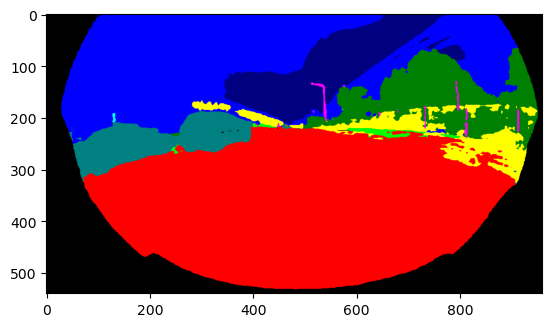

In [ ]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define a custom colormap mapping values 0-11 to specific colors
custom_colormap = [
    (255, 0, 0),   # Red for 0
    (0, 255, 0),   # Green for 1
    (0, 0, 255),   # Blue for 2
    (255, 255, 0), # Yellow for 3
    (255, 0, 255), # Magenta for 4
    (0, 255, 255), # Cyan for 5
    (128, 0, 0),   # Maroon for 6
    (0, 128, 0),   # Green for 7
    (0, 0, 128),   # Navy for 8
    (128, 128, 0), # Olive for 9
    (128, 0, 128), # Purple for 10
    (0, 128, 128),  # Teal for 11
    (0,0,0) # 12영역
]

# Convert the image to a NumPy array
image_array = np.array(new)
iamge_array = image_array.astype(np.uint8)

# Create an array for the colored image
colored_image = np.zeros((image_array.shape[0], image_array.shape[1], 3), dtype=np.uint8)

# Map the grayscale values to colors using the custom colormap
for i in range(13):
    colored_image[image_array == i] = custom_colormap[i]

# Create a Pillow image from the NumPy array
colored_image_pil = Image.fromarray(colored_image)
# colored_image_pil = colored_image_pil.resize((833, 467), Image.NEAREST)

# Display the image using matplotlib
plt.imshow(colored_image_pil)
# plt.axis('off')  # Turn off axis labels and ticks
plt.show()